Gradient descent is a systematic way to *minimize* a function, improving on naive “guess and check” by using information from derivatives to guide where to move next. [geeksforgeeks](https://www.geeksforgeeks.org/machine-learning/gradient-descent-algorithm-and-its-variants/)

### Guess and check approach

- A fourth‑degree polynomial function in $x$ that has two local minima, makes it a good toy “loss surface” to explore ideas of optimization and local vs global minima. [ruder](https://www.ruder.io/optimizing-gradient-descent/)

- A simple strategy is to try many candidate $x$ values over a range and pick the one that gives the smallest function value; this works in 1D but becomes inefficient and unreliable in higher dimensions or if the true minimum lies outside the guessed range. [ruder](https://www.ruder.io/optimizing-gradient-descent/)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px

In [2]:
def arbitrary(x):
    return (x**4 - 15*x**3 + 80*x**2 - 180*x + 144)/10

x = np.linspace(1, 6.75, 200)
px.line(y = arbitrary(x), x = x)

### Using numerical minimization

- A general minimization routine (like `scipy.optimize.minimize`) takes a function and a starting guess and iteratively searches for a nearby minimum, returning both the minimizing $x$ and the corresponding function value. [geeksforgeeks](https://www.geeksforgeeks.org/machine-learning/gradient-descent-algorithm-and-its-variants/)

- Because the surface has multiple minima, the result depends on the starting point: starting near the left well converges to the left local minimum, while starting on the right converges to the right (lower) minimum, illustrating the idea of local vs global minima. [ruder](https://www.ruder.io/optimizing-gradient-descent/)

In [3]:
from scipy.optimize import minimize

minimize(arbitrary, x0 = 6)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.6914096788729693
        x: [ 5.326e+00]
      nit: 7
      jac: [-3.055e-06]
 hess_inv: [[ 4.747e-01]]
     nfev: 16
     njev: 8

In [4]:
minimize(arbitrary, x0 = 1)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.13827491294422317
        x: [ 2.393e+00]
      nit: 7
      jac: [-3.800e-07]
 hess_inv: [[ 7.475e-01]]
     nfev: 16
     njev: 8

### Limitations of brute‑force search

- Pre‑specifying a grid of guesses has three issues: the minimum might lie outside the grid, the grid might be too coarse to get an accurate answer, and the required number of guesses becomes intractable in high dimensions. [ruder](https://www.ruder.io/optimizing-gradient-descent/)

- This highlights why a more intelligent procedure that uses local shape information (derivatives) is needed, especially when optimizing many parameters as in linear or logistic regression. [geeksforgeeks](https://www.geeksforgeeks.org/machine-learning/gradient-descent-algorithm-and-its-variants/)

In [5]:
def simple_minimize(f, xs):
    y = [f(x) for x in xs]  
    return xs[np.argmin(y)]

In [6]:
simple_minimize(arbitrary, np.linspace(1, 7, 20))

np.float64(5.421052631578947)

In [7]:
xs = np.linspace(1, 7, 200)
sparse_xs = np.linspace(1, 7, 5)

ys = arbitrary(xs)
sparse_ys = arbitrary(sparse_xs)

fig = px.line(x = xs, y = arbitrary(xs))
fig.add_scatter(x = sparse_xs, y = arbitrary(sparse_xs), mode = "markers")
fig.update_layout(showlegend= False)
fig.show()

### Role of the derivative

- The derivative of a 1D function tells you whether the function is increasing or decreasing at a point: negative derivative means the function is sloping downward (move right to go “downhill”); positive derivative means it is sloping upward (move left). [en.wikipedia](https://en.wikipedia.org/wiki/Gradient_descent)

- Plotting both the function and its derivative shows that points where the derivative is zero correspond to flat spots on the function—these are candidates for minima or maxima and are the points gradient descent is effectively trying to reach. [en.wikipedia](https://en.wikipedia.org/wiki/Gradient_descent)

In [8]:
import plotly.graph_objects as go

def derivative_arbitrary(x):
    return (4*x**3 - 45*x**2 + 160*x - 180)/10

def line(x):
    return (0*x)

fig = go.Figure()
fig.add_trace(go.Scatter(x = xs, y = arbitrary(xs), 
                         mode = "lines", name = "f"))
fig.add_trace(go.Scatter(x = xs, y = derivative_arbitrary(xs), 
                         mode = "lines", name = "df", line = {"dash": "dash"}))
fig.add_trace(go.Scatter(x = xs, y =line(xs), 
                         mode = "lines", name = "zero"))
fig.update_layout(font_size = 20, yaxis_range=[-1, 3])
fig.show()

In [9]:
import matplotlib.pyplot as plt

def plot_arbitrary():
    x = np.linspace(1, 7, 100)
    plt.plot(x, arbitrary(x))
    axes = plt.gca()
    axes.set_ylim([-1, 3])
    
def plot_x_on_f(f, x):
    y = f(x)
    default_args = dict(label=r'$ \theta $', zorder=2,
                        s=200, c=sns.xkcd_rgb['green'])
    plt.scatter([x], [y], **default_args)
    
def plot_x_on_f_empty(f, x):
    y = f(x)
    default_args = dict(label=r'$ \theta $', zorder=2,
                        s=200, c = 'none', edgecolor=sns.xkcd_rgb['green'])
    plt.scatter([x], [y], **default_args)    
    
def plot_tangent_on_f(f, x, eps=1e-6):
    slope = ((f(x + eps) - f(x - eps))
             / (2 * eps))
    xs = np.arange(x - 1, x + 1, 0.05)
    ys = f(x) + slope * (xs - x)
    plt.plot(xs, ys, zorder=3, c=sns.xkcd_rgb['green'], linestyle='--')    

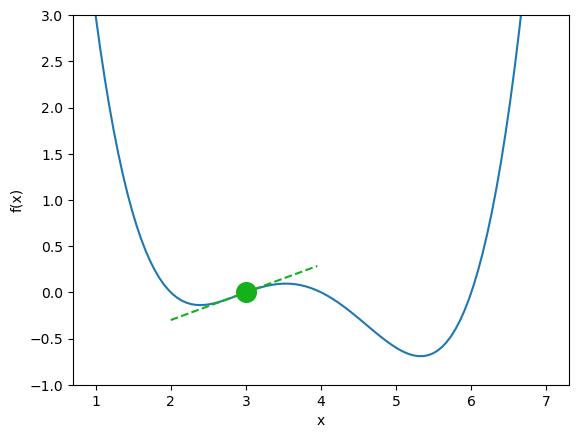

In [10]:
plot_arbitrary()
plot_x_on_f(arbitrary, 3)
plot_tangent_on_f(arbitrary, 3)
plt.xlabel('x')
plt.ylabel('f(x)');

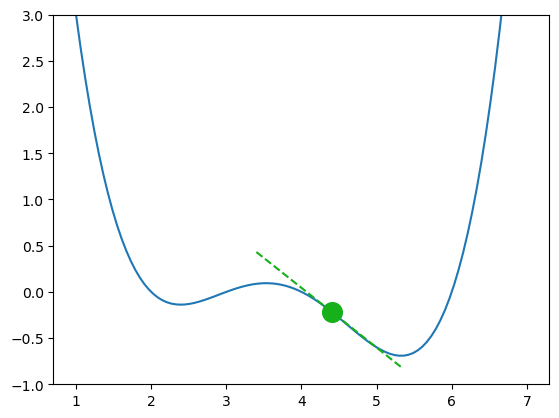

In [11]:
plot_arbitrary()
plot_x_on_f(arbitrary, 4.4)
plot_tangent_on_f(arbitrary, 4.4)

### Intuition for gradient descent

- The core insight is: use the sign and magnitude of the derivative to decide how to update $x$ step‑by‑step, moving opposite the derivative (downhill) until reaching a point where the derivative is approximately zero. [geeksforgeeks](https://www.geeksforgeeks.org/machine-learning/gradient-descent-algorithm-and-its-variants/)

- In higher dimensions this generalizes from a derivative to a **gradient** vector; gradient descent repeatedly moves parameters in the negative gradient direction to minimize a loss function, which is exactly what is done when training many machine learning models. [geeksforgeeks](https://www.geeksforgeeks.org/machine-learning/gradient-descent-algorithm-and-its-variants/)

### Manual gradient steps

- The function and its analytical derivative $f'(x)$ are both coded, so at any guess $x$ you can compute $x$, $f(x)$, and $f'(x)$ and print them out to inspect how the function and slope behave.  
- Starting from an initial guess (like $x = 4$), the derivative is slightly negative, so the next guess is taken as $x_{\text{new}} = x_{\text{old}} + 0.4$, moving right because a negative slope means the function is decreasing in that direction.

In [12]:
guess = 4
print(f"x: {guess}, f(x): {arbitrary(guess)}, derivative f'(x): {derivative_arbitrary(guess)}")

x: 4, f(x): 0.0, derivative f'(x): -0.4


In [13]:
guess = 4 + 0.4
print(f"x: {guess}, f(x): {arbitrary(guess)}, derivative f'(x): {derivative_arbitrary(guess)}")

x: 4.4, f(x): -0.21504000000003315, derivative f'(x): -0.6464000000000055


### Overshooting the minimum

- Repeating this “new guess = old guess ± derivative” rule moves the guess closer to the minimum, but as the slope gets steeper, the step sizes grow and the updates begin to overshoot the minimum back and forth.  
- A helper function (like `plot_one_step`) visualizes each step, making it clear that the guesses jump from one side of the minimum to the other, leading to oscillatory behavior instead of smooth convergence.

In [14]:
def plot_one_step(x):
    new_x = x - derivative_arbitrary(x)
    plot_arbitrary()
    plot_x_on_f(arbitrary, new_x)
    plot_x_on_f_empty(arbitrary, x)
    print(f'old x: {x}')
    print(f'new x: {new_x}')    

old x: 4
new x: 4.4


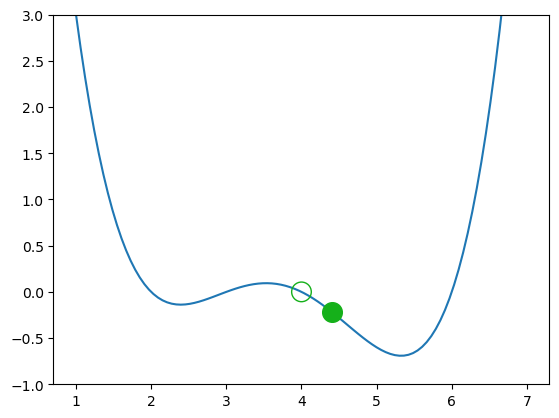

In [15]:
plot_one_step(4)

old x: 4.4
new x: 5.0464000000000055


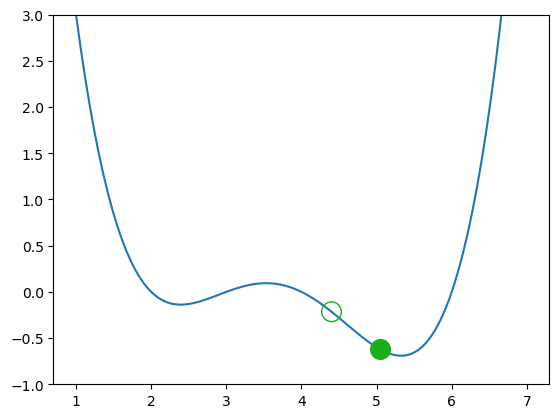

In [16]:
plot_one_step(4.4)

old x: 5.0464
new x: 5.49673060106241


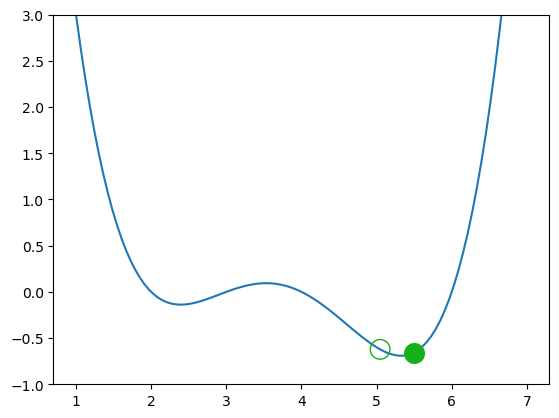

In [17]:
plot_one_step(5.0464)

### Introducing a learning rate

- To fix the overshooting, the update is modified to use only a fraction of the derivative: $x_{\text{new}} = x_{\text{old}} - \eta f'(x)$, where $\eta$ is a small constant (for example, $0.3$).  
- With this scaled step, another helper (e.g., `plot_one_step_better`) shows that each move is smaller, the sequence of guesses approaches the minimum more slowly but much more stably, and repeated application will eventually converge.

In [18]:
def plot_one_step_better(x):
    new_x = x - 0.3 * derivative_arbitrary(x)
    plot_arbitrary()
    plot_x_on_f(arbitrary, new_x)
    plot_x_on_f_empty(arbitrary, x)
    print(f'old x: {x}')
    print(f'new x: {new_x}')    

old x: 4
new x: 4.12


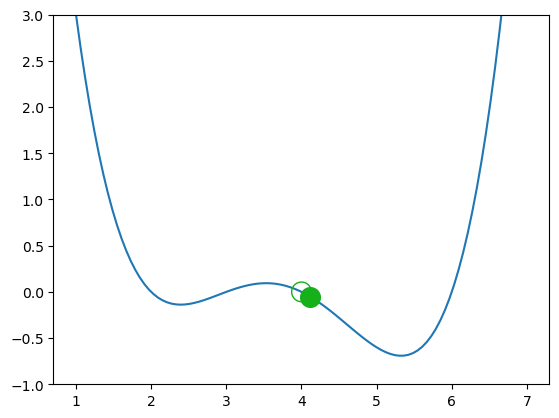

In [19]:
plot_one_step_better(4)

old x: 4.12
new x: 4.267296639999997


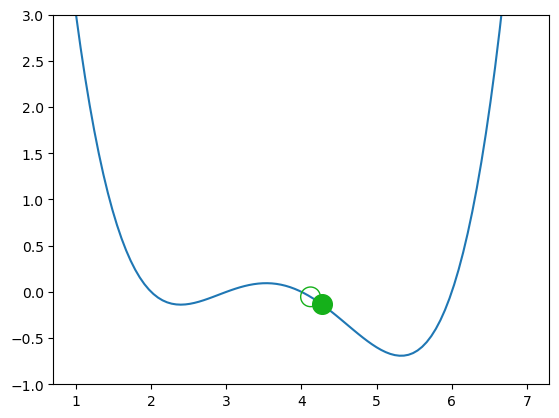

In [20]:
plot_one_step_better(4.12)

### Connection to full gradient descent

- The pattern “compute derivative → update guess by subtracting a scaled derivative → repeat” is exactly the core update rule of gradient descent.  
- In practical machine learning, this same idea is applied to parameters (weights) of models and extended with loops and stopping criteria to automate many steps instead of doing each one manually.

Sources:

[realpython](https://realpython.com/gradient-descent-algorithm-python/)   
[towardsdatascience](https://towardsdatascience.com/implementing-gradient-descent-in-python-from-scratch-760a8556c31f/)